# LLB parameter implementation

In [1]:
import numpy as np
from scipy import constants as sp
from scipy import optimize as op
from scipy import interpolate as ip
from matplotlib import pyplot as plt

## (Magnetic) material class

I define a class that should compute and hold all the relevant parameters needed for the LLB computation. This class holds only material-specific parameters, while interactions between different materials should be defined and imported from the Structure class.

In [2]:
class material():
    def __init__(self, name, S, Tc, lamda, muat):
        self.name=name                                      # name of the material used for the string representation of the class
        self.S=S                                            # effective spin
        self.Tc=Tc                                          # Curie temperature
        self.J=3*self.S/(self.S+1)*sp.k*self.Tc             # mean field exchange coupling constant
        self.mean_mag_map=create_mean_mag_map(self)        # creates the mean magnetization map over temperature as an interpolation function
        self.mean_mag_deriv=create_mean_mag_deriv(self)    # creates the mean magnetization derivative of temperature as an interpolation function
        self.lamda=lamda                                    # intrinsic coupling to bath parameter
        self.muat=muat                                      # atomic magnetic moment

In [3]:
    def __str__(self):
        return self.name

### Creation of the mean magnetization map

Here a temperature map of the mean field magnetization $m_{eq}(T)$ is created.
This means solving the self consistent equation

\begin{eqnarray}
    m_{eq}(T)&=&B_S(m_{eq}, T) \label{meq_def} \\
    B_S(m, T)&=& \frac{2 S+1}{2S} \coth{(\frac{2S+1}{2S}\frac{\text{self.}Jm}{k_BT})}-\frac{1}{2S} \coth{(\frac{1}{2S} \frac{\text{self.}Jm}{k_B T})} \label{Brillouin},
\end{eqnarray}

where

\begin{align}
\text{self.}J=3\frac{S}{S+1}k_B \ \text{self.}T_C
\end{align}

is the mean field exchange coupling constant for effective spin self.$S$ and Curie temperature self.$T_C$

In [4]:
    def create_mean_mag_map(self):
        # This function computes the mean field mean magnetization map by solving the self-consistent equation m=B(m, T)
        # As an output we get an interpolation function of the mean field magnetization at any temperature T<=T_c (this can of course be extended to T>T_c with zeros).
        # I have not worried about m<0 yet but this should be a quick implementation by mirroring the interpolation function later on in the code.

        # Start by defining a unity function m=m:
        def mag(m):
            return m

        # Define the Brillouin function as a function of scalars, as fsolve takes functions of scalars:
        def Brillouin(m, T):
            # This function takes input parameters
            #   (i) magnetization amplitude m_amp_grid (scalar)
            #   (ii) (electron) temperature (scalar)
            # As an output we get the Brillouin function evaluated at (i), (ii) (scalar)

            eta = self.J * m / sp.k / T /self.Tc
            c1 = (2 * self.S + 1) / (2 * self.S)
            c2 = 1 / (2 * self.S)
            bri_func = c1 / np.tanh(c1 * eta) - c2 / np.tanh(c2 * eta)
            return bri_func

        # Then we also need a temperature grid. I'll make it course grained for low temperatures (<0.8*Tc) (small slope) and fine grained for large temperatures (large slope):
        temp_grid=np.array(list(np.arange(0, 0.8, 1e-3))+list(np.arange(0.8, 1+1e-5, 1e-5)))

        # I will define the list of m_eq(T) here and append the solutions of m=B(m, T). It will have the length len(temp_grid) at the end.
        meq_list=[1.]

        # Define a function to find the intersection of m and B(m, T) for given T with scipy:
        def find_intersection_sp(m, Bm, m0):
            return op.fsolve(lambda x: m(x) - Bm(x), m0)

        # Find meq for every temperature, starting point for the search being (1-T/Tc)^(1/2), fill the list
        for i,T in enumerate(temp_grid[1:]):
            # Redefine the Brillouin function to set the temperature parameter (I did not find a more elegant solution to this):
            def Brillouin_2(m):
                return Brillouin(m, T)
            # Get meq:
            meq=find_intersection_sp(mag, Brillouin_2, np.sqrt(1-T))
            if meq[0]<0:            # This is a comletely unwarranted fix for values of meq<0 at temperatures very close to Tc, that fsolve produces. It seems to work though, as the interpolated function plotted by plot_mean_mags() seems clean.
                meq[0]*=-1
            # Append it to list me(T)
            meq_list.append(meq[0])
        meq_list[-1]=0              # This fixes slight computational errors to fix m_eq(Tc)=0 (it produces something like m_eq[-1]=1e-7)
        return ip.interp1d(temp_grid, meq_list)

### Creation of the derivative of the mean magnetization map

From the mean_mag_map one can easily define the derivative by temperature as well, which is computed by

\begin{align}
\frac{dm_{eq}}{dT} \approx \frac{\Delta m_{eq}}{\Delta T} 
\end{align}

on the same temperature grid chosen in the function above.

In [5]:
    def create_mean_mag_deriv(self):
        # This function returns the derivative of the mean magnetization map, needed to compute the longitudinal susceptibility. This can be included in create_mean_mag_map but I seperated it for clarity.
        temp_grid=np.array(list(np.arange(0, 0.8, 1e-3))+list(np.arange(0.8, 1+1e-5, 1e-5)))
        temp_diff=np.diff(temp_grid)
        return ip.interp1d(temp_grid[:-1], np.diff(self.mean_mag_map(temp_grid))/temp_diff)

### Calling the mean field magnetization and it's derivative

In the __init()__ function, the maps of mean field magnetization and its derivative are called and saved. To call the function for any array of temperatures we define the get_ functions 

In [6]:
    def get_mean_mag(self, T):
        # After creating the map, this function can be called to give m_eq at any temperature
        # The function takes a 1d-array of temperatures as an input (temperature map at each timestep) and returns an array with the respective mean field equilibrium temperatures
        tcmask=T<1.
        meq=np.zeros(len(T))
        meq[tcmask]=self.mean_mag_map(T[tcmask])
        return meq

    def get_mean_mag_deriv(self, T):
        tcmask=T<1.
        dmeq_dT=np.zeros(len(T))
        dmeq_dT[tcmask]=self.mean_mag_deriv(T[tcmask])
        return dmeq_dT

### Temperature dependent longotudinal and transverse dampin parameters

Here we define functions of temperature T that return the damping parameters of the LLB:

\begin{eqnarray}
\alpha_{\parallel} &=& \frac{2\lambda}{S+1}\frac{1}{\sinh(2q_s)}\\
\alpha_{\perp} &=& \frac{\lambda}{m_{eq}(T)}(\frac{\tanh(q_s)}{q_s}-\frac{T}{T_C}),
\end{eqnarray}

where

\begin{align}
q_s=\frac{3 T_C m_{eq}(T)}{(2S+1)T}
\end{align}

In [7]:
    def alpha_par(self, T):
        # This funtion computes the longitudinal damping parameter alpha_parallel
        return 2*self.lamda/(self.S+1)*1/np.sinh(3*self.Tc*self.mean_mag_map(T)/(self.S+1)*T)

    def alpha_trans(self, T):
        # This function computes the transverse damping parameter alpha_transverse
        meq=self.mean_mag_map(T)
        qs=3*self.Tc*meq/(2*self.S+1)/T
        return self.lamda/meq*(np.tanh(qs)/qs-T/3/self.Tc)

## Creating some sample structure

In [8]:
def get_sample():
    # This is a dummy function that should definitely be replaced by outputs from your code. It does not take any input parameters as I define everything here.
    # As an output we get
    #   (i) a 1d list of M materials within the sample (materials on the scale of the grainsize of the macrospins)
    #   (ii) a 1d numpy array of the actual sample consisting of stacked layers of the M materials
    #   (iii-v) magnetization amplitudes and angles
    
    # Define define three dummy materials with different parameters:
    mat_1 = material('uno', 1/2, 650., 0.01, 2.)
    mat_2 = material('dos', 7/2, 1200., 0.015, 1.)
    mat_3 = material('tres', 1, 300., 0.02, 1.5)
    materials=[mat_1, mat_2, mat_3]

    # Define a sample structure where 5 layers of each material build blocks that are periodically stacked 10 times (5*3*10=150=N):
    building_block=np.concatenate((np.array([mat_1 for _ in range(5)]), np.array([mat_2 for _ in range(5)]), np.array([mat_3 for _ in range(5)])))
    sample=np.concatenate([building_block for _ in range(10)])

    #Define initial magnetization on the whole sample (for simplicity uniform) and fully magnetized along the z-axis
    m_amp = np.ones(150)
    m_phi = np.zeros(150)
    m_gamma = np.zeros(150)
    return materials, sample, m_amp, m_phi, m_gamma

## Creating magnetization vectors

In [9]:
def get_mag(amp, gamma, phi):
    # This function takes as input parameters the amplitude and angles (A1, A2, A3) and puts out a numpy array of dimension 3xN
    # with 3 magnetization components for N unit cells

    mx=amp*np.cos(gamma)*np.sin(phi)
    my=amp*np.sin(gamma)*np.sin(phi)
    mz=amp*np.cos(phi)
    return(mx, my, mz)

## Plotting functions for the $m_{eq}(T)$ maps

This should really work for any sample preperation..

In [35]:
def plot_mean_mags(materials):
    #define a temperature grid:
    temps=np.arange(0,2+1e-4, 1e-4)
    temps[-1]=1.
    for i,m in enumerate(materials):
        mmag=get_mean_mag(m, temps)
        label=str(m.name)
        plt.plot(temps*m.Tc, mmag, label=label)

    plt.xlabel(r'Temperature [K]', fontsize=16)
    plt.ylabel(r'$m_{\rm{eq}}$', fontsize=16)
    plt.legend(fontsize=14)
    plt.title(r'$m_{\rm{eq}}$ for all materials in sample', fontsize=18)
    plt.savefig('plots/meqtest.pdf')
    plt.show()

In [38]:
def plot_mean_mag_derivs(materials):
    #define a temperature grid:
    temps=np.arange(0,2+1e-4, 1e-4)
    temps[-1]=1.
    for i,m in enumerate(materials):
        dTmmag=get_mean_mag_deriv(m, temps)
        label=str(m.name)
        plt.plot(temps*m.Tc, dTmmag, label=label)

    plt.xlabel(r'Temperature [K]', fontsize=16)
    plt.ylabel(r'$\partial_Tm_{\rm{eq}}$ [1/K]', fontsize=16)
    plt.legend(fontsize=14)
    plt.title(r'Derivative of $m_{\rm{eq}}$ for all materials in sample', fontsize=18)
    plt.savefig('plots/dmeqdTtest.pdf')
    plt.show()

In [12]:
materials, sample, m_amp, m_phi, m_gamma=get_sample()

C:\Users\tgrie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


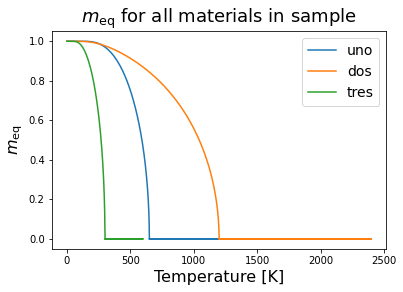

In [39]:
plot_mean_mags(materials)

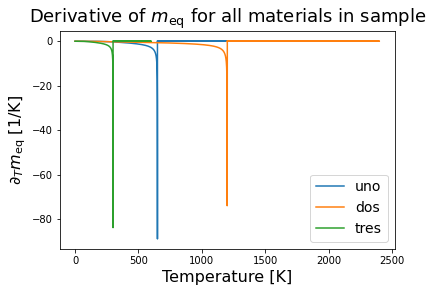

In [40]:
plot_mean_mag_derivs(materials)

## Exchange coupling between grains of arbitrary materials

### Matrix of coupling constants

The follwoing peace of code defines a symmetric matrix of dimension len(materials)xlen(materials) (here three, indices a,b,c) between potential neighbouring grains with indices i,j

\begin{align}
    \mathcal{J}_{ij}= \left( \begin{matrix}J_{aa} \ J_{ab} \ J_{ac} \\ J_{ba} \ J_{bb} \ J_{cb} \\ J_{ca} \ J_{cb} \ J_{cc}\end{matrix} \right),
\end{align}

where $J_{lk}=J_{kl}$ for $k,l \in [a,b,c]$ 
and $J_{ll}=3 \frac{l.S}{l.S+1} k_B \ l.T_C$ is just the mean field exchange coupling constant for material $l$.

### Construction of exchange coupling array

Now one can fill the array exch_coup_arr with the respective coupling constants of neighbouring grains as defined in sample. 
For a sample of five grains

$[mat1, mat2, mat3, mat3, mat1]$

this would produce

$[[0, J_{12}],[J_{21}, J_{23}],[J_{32}, J_{33}],[J_{33}, J_{31}],[J_{31}, 0]]$

This function just needs to be called once to create the proper interaction array for the simulated sample.

In [29]:
def get_exch_coup_sam(materials, sample):
    # This function takes as input parameters:
    #   (i) the 1d-list of magnetic unique materials in the sample (size M)
    #   (ii) the 1d numpy array of the sample, consisting of a material (from class material) at each grain (size N)
    # As an output we get a 2d numpy array of dimension Nx2 for coupling each site with its 2 neighbours in the linear chain of grains.

    # Define a matrix J_mat of dimension len(materials)xlen(materials) with the exchange coupling constants of mat_i and mat_j at J_mat[i][j]=J_mat[j][i]
    J_mat=np.zeros((len(materials), len(materials)))
    # fill the diagonal with the mean field exchange constant of each material:
    for i, mat in enumerate(materials):
        J_mat[i][i]=mat.J
    # define the off-diagonals, namely some values for exchange coupling constants of different materials:
    J_mat[0][1]=1e-20
    J_mat[1][2]=5e-20
    J_mat[0][2]=1e-19
    # symmetrize the matrix so that also elements [i][j] with i>j can be read out:
    for i in range(1,len(materials)):
        for j in range(i):
            J_mat[i][j]=J_mat[j][i]

    # Now we can assign the coupling of each grain to its nearest neighbours by filling the output array with the respective matrix entry:
    # Let's define the output array:
    ex_coup_arr=np.zeros((len(sample),2))
    # For this I fill a list with the indices of the respective materials:
    mat_indices=[materials.index(grain) for grain in sample]
    # This list can assign the proper matrix elements to the output matrix
    for i, grain in enumerate(sample):
        if i>0:
            ex_coup_arr[i][0]=J_mat[mat_indices[i]][mat_indices[i-1]]
        if i<len(sample)-1:
            ex_coup_arr[i][1]=J_mat[mat_indices[i]][mat_indices[i+1]]
    return ex_coup_arr

In [30]:
exch_coup_const=get_exch_coup_sam(materials, sample)